# G. Audio Classifier for the LAV-DF Dataset

Setup & Installation

In [ ]:
from google.colab import drive
import os
import glob
import random
import numpy as np

drive.mount('/content/drive')
DATA_ROOT = '/content/drive/My Drive/Deep Fake Dataset'

try:
    os.chdir(DATA_ROOT)
    print(f"Working Directory: {os.getcwd()}")
except Exception as e:
    print(f"Error: {e}")

Mounted at /content/drive
Working Directory: /content/drive/.shortcut-targets-by-id/122_EfIpP6SceFMPeBakKwIQV2RWQRRjW/Deep Fake Dataset


In [ ]:
!pip install -q librosa soundfile pydub tqdm

In [ ]:
import os
from glob import glob
from tqdm import tqdm
import numpy as np
import librosa
import soundfile as sf
from pathlib import Path
from pydub import AudioSegment
import subprocess

In [ ]:
# Path to MP4 files
TRAIN_DIR = os.path.join(DATA_ROOT, 'LAV-DF', 'train')

# Where to save WAVs
WAV_CONVERT_DIR = os.path.join(DATA_ROOT, 'wav_converted')
os.makedirs(WAV_CONVERT_DIR, exist_ok=True)

# Where to save features
FEATURE_DIR = os.path.join(DATA_ROOT, 'features')
os.makedirs(FEATURE_DIR, exist_ok=True)

TARGET_SR = 16000

Feature Extraction: Helper Functions

In [ ]:
#convert audio to WAV form
def ensure_wav(input_path_to_read_audio, original_file_rel, out_dir, target_sr=TARGET_SR):
    """
    Ensure audio is WAV (PCM 16-bit) with sample rate target_sr.
    - input_path_to_read_audio: The actual path to the audio file (could be local temp or Drive path).
    - original_file_rel: The relative path of the file *within the original dataset structure*
                         (e.g., 'train/000001.mp4'). This is used to reconstruct output paths.
    - Otherwise converts using pydub or ffmpeg to out_dir and returns converted path.
    - Converted files keep relative structure to avoid collisions.
    """
    input_path_to_read_audio = str(input_path_to_read_audio)

    # Use original_file_rel to determine the output subdirectory structure
    rel_dir_part = os.path.dirname(original_file_rel)
    out_subdir = os.path.join(out_dir, rel_dir_part)
    os.makedirs(out_subdir, exist_ok=True)

    out_name = Path(original_file_rel).stem + '.wav'
    out_path = os.path.join(out_subdir, out_name)

    # If already converted and exists, return it
    if os.path.exists(out_path):
        return out_path

    # Convert using pydub
    try:
        audio = AudioSegment.from_file(input_path_to_read_audio) # autodetect format
        # set frame rate / sample width (16-bit)
        audio = audio.set_frame_rate(int(target_sr)).set_sample_width(2).set_channels(1)
        audio.export(out_path, format='wav')
    except Exception:
        cmd = [
            'ffmpeg', '-y', '-i', input_path_to_read_audio,
            '-ar', str(target_sr), '-ac', '1', '-sample_fmt', 's16', out_path
        ]
        subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    return out_path

In [ ]:
#to convert to numpy array
def load_audio_mono(path, sr):
    """
    Loads audio as mono float32 array using librosa.
    - sr: target sample rate (resampling will occur if needed)
    - duration: if provided (seconds), loads that much from start
    Returns: y (np.float32), sr (int)
    """
    y, sr = librosa.load(path, sr=sr, mono=True)
    return y, sr

In [ ]:
def extract_basic_features(y, sr):
    """
    Extracts a wide set of audio features useful for deepfake detection.
    Each feature includes explanatory comments for clarity.
    Returns a dictionary mapping: feature_name -> numpy array or scalar.
    """

    features = {}

    # 1. MFCCs (Mel-frequency cepstral coefficients)
    # (describe the timbre/character of the voice)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features['mfcc_mean'] = np.mean(mfcc, axis=1)  # average value per coefficient
    features['mfcc_std']  = np.std(mfcc, axis=1)   # variation of each coefficient


    # 2. Delta MFCCs (First derivative / velocity)
    # (how MFCCs change over time)
    delta_mfcc = librosa.feature.delta(mfcc, order=1)
    features['mfcc_delta_mean'] = np.mean(delta_mfcc, axis=1)
    features['mfcc_delta_std']  = np.std(delta_mfcc, axis=1)

    # 3. Mel-spectrogram (mean across time)
    # (how energy is distributed across mel frequency bands)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024,
                                         hop_length=512, n_mels=40)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    features['mel_mean'] = np.mean(log_mel, axis=1)  # avg energy in each mel band

    # 4. Spectral Contrast
    # (contrast between peaks and valleys in frequency)
    spec_con = librosa.feature.spectral_contrast(y=y, sr=sr,
                                                 n_fft=1024, hop_length=512)
    features['spec_con_mean'] = np.mean(spec_con, axis=1)

    # 5. Chroma Features
    # (related to pitch class (12 chroma bins))
    chroma = librosa.feature.chroma_stft(y=y, sr=sr,
                                         n_fft=1024, hop_length=512)
    features['chroma_mean'] = np.mean(chroma, axis=1)


    # 6. Zero-Crossing Rate (ZCR)
    # (indicator of noisiness / fricatives)
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=1024,
                                             hop_length=512)
    features['zcr_mean'] = float(np.mean(zcr))
    features['zcr_std']  = float(np.std(zcr))

    # 7. Spectral Rolloff
    # (frequency below which 85% of energy is contained)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85,
                                               n_fft=1024, hop_length=512)
    features['rolloff_mean'] = float(np.mean(rolloff))
    features['rolloff_std']  = float(np.std(rolloff))


    # 8. Spectral Flatness
    # (measures tone-like vs noise-like quality)
    flatness = librosa.feature.spectral_flatness(y=y,
                                                 n_fft=1024, hop_length=512)
    features['flatness_mean'] = float(np.mean(flatness))
    features['flatness_std']  = float(np.std(flatness))


    # 9. RMS Energy
    # (overall loudness over time)
    rms = librosa.feature.rms(y=y, frame_length=1024,
                              hop_length=512)[0]
    features['rms_mean'] = float(np.mean(rms))
    features['rms_std']  = float(np.std(rms))


    return features

In [ ]:
def save_features(features_dict, src_audio_path, feature_dir=FEATURE_DIR):
    """
    Saves all extracted features for one audio file into a compressed .npz file.

    - Each feature becomes an array inside the .npz
    - File is named after the audio file (e.g., "example.wav" -> "example.npz")
    """

    # Turn the audio filepath into a safe filename
    stem = Path(src_audio_path).stem
    out_file = os.path.join(feature_dir, stem + '.npz')

    # Convert feature dictionary values to NumPy arrays before saving
    np_save_dict = {k: np.asarray(v) for k, v in features_dict.items()}

    # Save compressed file with all features inside
    np.savez_compressed(out_file, **np_save_dict)

    return out_file

Loading Metadata & Creating Dataframe

In [ ]:
# Step 1: load metadata.json and build a dataset table
import json
import os
from pathlib import Path
import pandas as pd

# Path to metadata file
DATA_ROOT = Path('/content/drive/My Drive/Deep Fake Dataset')
META_PATH = DATA_ROOT / 'LAV-DF' / 'metadata.json'

# Load and extract entries
with META_PATH.open('r', encoding='utf-8') as f:
    meta = json.load(f)

entries = (meta if isinstance(meta, list) else
           meta.get('root') or meta.get('items') or
           next((v for v in meta.values() if isinstance(v, list)), []))

# Build rows
rows = []
for e in entries:
    if not isinstance(e, dict):
        continue

    file_rel = e.get('file')
    rows.append({
        'file_rel': file_rel,
        'filepath': str(DATA_ROOT / 'LAV-DF' / file_rel) if file_rel else None,
        'split': e.get('split', 'unknown'),
        'duration': e.get('duration'),
        'transcript': e.get('transcript'),
        'n_fakes': int(e.get('n_fakes') or 0),
        'modify_audio': bool(e.get('modify_audio')),
        'modify_video': bool(e.get('modify_video')),
        'audio_channels': int(e.get('audio_channels') or 1),
        'audio_frames': int(e.get('audio_frames') or 0),
        'label': 'fake' if e.get('modify_audio') else 'real'
    })

df = pd.DataFrame(rows)
df['exists_on_disk'] = df['filepath'].apply(lambda p: os.path.exists(p) if p else False)

print(f"Total metadata entries: {len(df)}")
print(df['split'].value_counts(dropna=False))
print(df['label'].value_counts())
print(f"Files that exist on disk: {df['exists_on_disk'].sum()} / {len(df)}")
df.head(8)

# Filter to existing files, inspect counts, and save per-split CSVs

print(f"Prior total metadata rows: {len(df)}")

df_ok = df[df['exists_on_disk']].copy()
print(f"Usable files (exists_on_disk=True): {len(df_ok)}")
print("\nLabel distribution:")
print(df_ok['label'].value_counts())
print("\nSplit distribution:")
print(df_ok['split'].value_counts())
print("\nSample rows:")
display(df_ok[['file_rel','filepath','split','label','duration']].head(6))

# Save per-split CSVs
OUT_DIR = DATA_ROOT / 'metadata_splits'
OUT_DIR.mkdir(exist_ok=True)

cols = ['filepath','file_rel','label','duration','transcript','n_fakes','modify_audio','modify_video']
for split_name, df_split in df_ok.groupby('split'):
    out_path = OUT_DIR / f"{split_name}.csv"
    df_split[cols].to_csv(out_path, index=False)
    print(f"Saved {len(df_split)} rows -> {out_path}")

print(f"\nDone. Find CSVs in: {OUT_DIR}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Deep Fake Dataset/LAV-DF/metadata.json'

In [ ]:
# Stratified train/val/test split (70 / 15 / 15)
import pandas as pd
from sklearn.model_selection import train_test_split

# Paths
DATA_ROOT = '/content/drive/My Drive/Deep Fake Dataset'
IN_CSV = os.path.join(DATA_ROOT, 'metadata_splits', 'train.csv')
OUT_DIR = os.path.join(DATA_ROOT, 'metadata_splits')
os.makedirs(OUT_DIR, exist_ok=True)

# Parameters
RANDOM_SEED = 42
TRAIN_FRAC = 0.70
VAL_FRAC = 0.15
TEST_FRAC = 0.15

# 1) Load the CSV with usable files
df_all = pd.read_csv(IN_CSV)
print("Total examples in input CSV:", len(df_all))

# 2) First split: train vs temp (temp will become val+test)
train_df, temp_df = train_test_split(
    df_all,
    train_size=TRAIN_FRAC,
    stratify=df_all['label'],
    random_state=RANDOM_SEED,
    shuffle=True
)

# 3) Second split: split temp into val and test equally so each is 15% of total
val_rel_frac = VAL_FRAC / (1.0 - TRAIN_FRAC)

val_df, test_df = train_test_split(
    temp_df,
    train_size=val_rel_frac,
    stratify=temp_df['label'],
    random_state=RANDOM_SEED,
    shuffle=True
)

# 4) Save CSVs
train_out = os.path.join(OUT_DIR, 'split_train.csv')
val_out   = os.path.join(OUT_DIR, 'split_val.csv')
test_out  = os.path.join(OUT_DIR, 'split_test.csv')

train_df.to_csv(train_out, index=False)
val_df.to_csv(val_out, index=False)
test_df.to_csv(test_out, index=False)

# Print summaries to confirm
print("\nSaved splits to:", OUT_DIR)
print(f"Train: {len(train_df)} examples -> {train_out}")
print(f"Val:   {len(val_df)} examples -> {val_out}")
print(f"Test:  {len(test_df)} examples -> {test_out}")

print("\nLabel distribution (train / val / test):")
print("train:\n", train_df['label'].value_counts())
print("val:\n", val_df['label'].value_counts())
print("test:\n", test_df['label'].value_counts())

Total examples in input CSV: 25641

Saved splits to: /content/drive/My Drive/Deep Fake Dataset/metadata_splits
Train: 17948 examples -> /content/drive/My Drive/Deep Fake Dataset/metadata_splits/split_train.csv
Val:   3846 examples -> /content/drive/My Drive/Deep Fake Dataset/metadata_splits/split_val.csv
Test:  3847 examples -> /content/drive/My Drive/Deep Fake Dataset/metadata_splits/split_test.csv

Label distribution (train / val / test):
train:
 label
real    9254
fake    8694
Name: count, dtype: int64
val:
 label
real    1983
fake    1863
Name: count, dtype: int64
test:
 label
real    1983
fake    1864
Name: count, dtype: int64


Extracting Traditional Acoustic Features

In [ ]:
# feature extraction: copy to local tmp, convert locally, extract features, push small .npz to Drive
import os, time, csv, shutil
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# user config
DATA_ROOT = '/content/drive/My Drive/Deep Fake Dataset'
SPLIT_CSV = os.path.join(DATA_ROOT, 'metadata_splits', 'split_test.csv')
OUT_FEATURE_DIR = os.path.join(DATA_ROOT, 'features', 'test')
LOCAL_TMP = '/content/tmp_batch'
BATCH_SIZE = 50
MAX_RETRIES = 3
RETRY_SLEEP = 8
TARGET_SR = globals().get('TARGET_SR', 16000)
USE_LOCAL_BATCH = True
# ---------------------------------------------------------

# Make directories
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(LOCAL_TMP, exist_ok=True)

# processed-log so we can resume (store the names of the files)
processed_log = os.path.join(DATA_ROOT, 'features', f'processed_log_{Path(SPLIT_CSV).stem}.csv')
processed_set = set()
if os.path.exists(processed_log):
    with open(processed_log, 'r') as f:
        for r in f:
            r = r.strip()
            if r:
                processed_set.add(r)

# Load CSV
df = pd.read_csv(SPLIT_CSV)
n_total = len(df)
print(f"Rows to process: {n_total}")

# helper: retry wrapper
def with_retries(fn, max_retries=MAX_RETRIES, sleep=RETRY_SLEEP, *args, **kwargs):
    last_exc = None
    for attempt in range(1, max_retries+1):
        try:
            return fn(*args, **kwargs)
        except Exception as e:
            last_exc = e
            print(f"Attempt {attempt}/{max_retries} failed: {e}")
            time.sleep(sleep)
    raise last_exc

# safe chunked copy from Drive -> local
def copy_bytes(src, dest, chunk_size=1024*1024):
    os.makedirs(os.path.dirname(dest), exist_ok=True)
    with open(src, 'rb') as fr, open(dest, 'wb') as fw:
        while True:
            chunk = fr.read(chunk_size)
            if not chunk:
                break
            fw.write(chunk)

# save feature .npz on Drive
def save_features_for_row(features_dict, file_rel, out_dir=OUT_FEATURE_DIR):
    stem = Path(file_rel).stem
    out_file = os.path.join(out_dir, stem + '.npz')
    np_save = {k: np.asarray(v) for k, v in features_dict.items()}
    np.savez_compressed(out_file, **np_save)
    return out_file

# append to processed log
def log_processed(stem):
    with open(processed_log, 'a') as f:
        f.write(stem + "\n")
    processed_set.add(stem)

# Main loop: batches
rows = list(df.itertuples(index=False))
i = 0
while i < n_total:
    batch_rows = rows[i:i+BATCH_SIZE]
    i_end = i + len(batch_rows)
    print(f"\n=== Processing batch {i+1}-{i_end} / {n_total} ===")

    # prepare local copies for the batch
    if USE_LOCAL_BATCH:
        # clean local tmp (only files from previous batch to avoid stale leftovers)
        for fname in os.listdir(LOCAL_TMP):
            try:
                os.remove(os.path.join(LOCAL_TMP, fname))
            except Exception:
                pass

        # copy files to local tmp with retries
        for r in batch_rows:
            src_drive = getattr(r, 'filepath') if 'filepath' in df.columns else None
            file_rel = getattr(r, 'file_rel')
            local_name = Path(file_rel).name
            dest_local = os.path.join(LOCAL_TMP, local_name)
            if not src_drive:
                continue
            # do not copy if already exists locally
            if os.path.exists(dest_local):
                continue
            try:
                with_retries(lambda s=src_drive, d=dest_local: copy_bytes(s, d))
            except Exception as e:
                print(f"[COPY FAILED] {src_drive} -> {dest_local}: {e}")

    # process files in this batch
    for r in tqdm(batch_rows, desc="batch files"):
        file_rel = getattr(r, 'file_rel')
        stem = Path(file_rel).stem
        out_feature_path = os.path.join(OUT_FEATURE_DIR, stem + '.npz')

        # skip if processed or output exists
        if stem in processed_set or os.path.exists(out_feature_path):
            continue

        # determine source: local copy if present, else Drive path
        local_src = os.path.join(LOCAL_TMP, Path(file_rel).name)
        if os.path.exists(local_src):
            src_path = local_src
        else:
            src_path = getattr(r, 'filepath')

        try:
            # convert MP4 -> WAV locally into LOCAL_TMP (so ensure_wav should write there)
            wav_dir_local = LOCAL_TMP
            wav_path = with_retries(lambda p=src_path: ensure_wav(p, file_rel, out_dir=wav_dir_local, target_sr=TARGET_SR))

            # load audio (mono float32)
            y, sr = load_audio_mono(wav_path, sr=TARGET_SR)

            # extract features with function
            feats = extract_basic_features(y, sr)

            # save features to Drive
            saved = save_features_for_row(feats, file_rel, OUT_FEATURE_DIR)
            log_processed(stem)

            # cleanup local artifacts to free VM disk
            try:
                if os.path.exists(local_src): os.remove(local_src)
                if os.path.exists(wav_path): os.remove(wav_path)
            except Exception:
                pass

        except Exception as e:
            print(f"[ERROR] {file_rel}: {e}")
            # log the error for inspection
            errfile = os.path.join(DATA_ROOT, 'features', 'errors.txt')
            with open(errfile, 'a') as ef:
                ef.write(f"{file_rel}\t{repr(e)}\n")

    # advance to next batch
    i += BATCH_SIZE
    # brief cooldown
    time.sleep(2)

print("=== ALL BATCHES COMPLETE ===")
print("Features saved to:", OUT_FEATURE_DIR)
print("Processed count:", len(processed_set))

Processed (from log): 3847
Rows to process: 3847

=== Processing batch 1-50 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 89278.50it/s]



=== Processing batch 51-100 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 142276.26it/s]



=== Processing batch 101-150 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 120387.60it/s]



=== Processing batch 151-200 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 91339.37it/s]



=== Processing batch 201-250 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 114723.85it/s]



=== Processing batch 251-300 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 37841.07it/s]



=== Processing batch 301-350 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 88115.63it/s]



=== Processing batch 351-400 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 84054.19it/s]



=== Processing batch 401-450 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 85563.12it/s]



=== Processing batch 451-500 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 96155.52it/s]



=== Processing batch 501-550 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 90668.05it/s]



=== Processing batch 551-600 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 95152.09it/s]



=== Processing batch 601-650 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 129373.97it/s]



=== Processing batch 651-700 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 141987.27it/s]



=== Processing batch 701-750 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 53308.39it/s]



=== Processing batch 751-800 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 58189.57it/s]



=== Processing batch 801-850 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 96287.97it/s]



=== Processing batch 851-900 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 90394.48it/s]



=== Processing batch 901-950 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 126869.45it/s]



=== Processing batch 951-1000 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 99911.96it/s]



=== Processing batch 1001-1050 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 125427.75it/s]



=== Processing batch 1051-1100 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 104700.55it/s]



=== Processing batch 1101-1150 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 99816.85it/s]



=== Processing batch 1151-1200 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 98875.62it/s]



=== Processing batch 1201-1250 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 88189.74it/s]



=== Processing batch 1251-1300 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 112993.10it/s]



=== Processing batch 1301-1350 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 134432.82it/s]



=== Processing batch 1351-1400 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 91419.01it/s]



=== Processing batch 1401-1450 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 89775.34it/s]



=== Processing batch 1451-1500 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 85354.17it/s]



=== Processing batch 1501-1550 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 112629.00it/s]



=== Processing batch 1551-1600 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 50207.13it/s]



=== Processing batch 1601-1650 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 96376.47it/s]



=== Processing batch 1651-1700 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 95108.93it/s]



=== Processing batch 1701-1750 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 94254.02it/s]



=== Processing batch 1751-1800 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 91538.72it/s]



=== Processing batch 1801-1850 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 91658.74it/s]



=== Processing batch 1851-1900 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 93206.76it/s]



=== Processing batch 1901-1950 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 91538.72it/s]



=== Processing batch 1951-2000 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 32615.12it/s]



=== Processing batch 2001-2050 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 89890.78it/s]



=== Processing batch 2051-2100 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 36830.91it/s]



=== Processing batch 2101-2150 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 124165.30it/s]



=== Processing batch 2151-2200 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 94893.76it/s]



=== Processing batch 2201-2250 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 89316.52it/s]



=== Processing batch 2251-2300 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 97045.44it/s]



=== Processing batch 2301-2350 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 68067.25it/s]



=== Processing batch 2351-2400 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 121785.83it/s]



=== Processing batch 2401-2450 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 83319.51it/s]



=== Processing batch 2451-2500 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 47265.09it/s]



=== Processing batch 2501-2550 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 139623.97it/s]



=== Processing batch 2551-2600 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 92304.23it/s]



=== Processing batch 2601-2650 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 94423.77it/s]



=== Processing batch 2651-2700 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 72390.47it/s]



=== Processing batch 2701-2750 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 89278.50it/s]



=== Processing batch 2751-2800 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 93664.67it/s]



=== Processing batch 2801-2850 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 90355.54it/s]



=== Processing batch 2851-2900 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 133321.81it/s]



=== Processing batch 2901-2950 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 98643.09it/s]



=== Processing batch 2951-3000 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 90825.12it/s]



=== Processing batch 3001-3050 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 95238.51it/s]



=== Processing batch 3051-3100 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 107271.20it/s]



=== Processing batch 3101-3150 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 79739.62it/s]



=== Processing batch 3151-3200 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 85111.69it/s]



=== Processing batch 3201-3250 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 83585.17it/s]



=== Processing batch 3251-3300 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 85843.31it/s]



=== Processing batch 3301-3350 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 85111.69it/s]



=== Processing batch 3351-3400 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 25609.38it/s]



=== Processing batch 3401-3450 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 94000.54it/s]



=== Processing batch 3451-3500 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 96509.53it/s]



=== Processing batch 3501-3550 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 95455.26it/s]



=== Processing batch 3551-3600 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 100438.31it/s]



=== Processing batch 3601-3650 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 89813.79it/s]



=== Processing batch 3651-3700 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 79018.54it/s]



=== Processing batch 3701-3750 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 95411.83it/s]



=== Processing batch 3751-3800 / 3847 ===


batch files: 100%|██████████| 50/50 [00:00<00:00, 92794.34it/s]



=== Processing batch 3801-3847 / 3847 ===


batch files: 100%|██████████| 47/47 [00:00<00:00, 93516.27it/s]


=== ALL BATCHES COMPLETE ===
Features saved to: /content/drive/My Drive/Deep Fake Dataset/features/test
Processed count: 3847


Building Dataset for ML

In [ ]:
# build full X/y matrices for train/val/test, standardize features (fit on train), and save to disk.
import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import joblib   # for saving scaler
from tqdm import tqdm

DATA_ROOT = '/content/drive/My Drive/Deep Fake Dataset'
META_DIR = os.path.join(DATA_ROOT, 'metadata_splits')
FEATURE_ROOT = os.path.join(DATA_ROOT, 'features')
OUT_DIR = os.path.join(DATA_ROOT, 'ml_ready_datasets')
os.makedirs(OUT_DIR, exist_ok=True)

def flatten_features(npz_dict):
    """
    Convert a dict loaded from .npz into a single flat 1D numpy array.
    Preserves deterministic ordering by sorting keys alphabetically.
    """
    flat_list = []
    for key in sorted(npz_dict.keys()):
        value = npz_dict[key]
        arr = np.asarray(value).ravel()
        flat_list.append(arr)
    return np.concatenate(flat_list, axis=0)

def load_split_to_Xy(split_csv, feature_subdir):
    """
    Load all .npz features for the split described in split_csv.
    Returns: X (n_samples x n_features), y (n_samples,), missing_list
    """
    df = pd.read_csv(split_csv)
    X_list = []
    y_list = []
    missing = []
    feat_dir = os.path.join(FEATURE_ROOT, feature_subdir)

    print(f"Loading features from: {split_csv}")
    for row in tqdm(df.itertuples(index=False), total=len(df), desc=f"Loading {feature_subdir}"):
        file_rel = getattr(row, 'file_rel')
        label = getattr(row, 'label')
        stem = Path(file_rel).stem
        feat_path = os.path.join(feat_dir, stem + '.npz')

        if not os.path.exists(feat_path):
            missing.append(stem)
            continue

        data = np.load(feat_path)
        x_vec = flatten_features(data)
        X_list.append(x_vec)
        y_list.append(1 if label == 'fake' else 0)

    if len(X_list) == 0:
        return np.zeros((0,0)), np.array([]), missing

    X = np.vstack(X_list)
    y = np.array(y_list, dtype=np.int64)
    return X, y, missing


# Load splits
train_csv = os.path.join(META_DIR, 'split_train.csv')
val_csv   = os.path.join(META_DIR, 'split_val.csv')
test_csv  = os.path.join(META_DIR, 'split_test.csv')

print("Loading TRAIN split features...")
X_train, y_train, m_train = load_split_to_Xy(train_csv, 'train')
print("Loading VAL split features...")
X_val,   y_val,   m_val   = load_split_to_Xy(val_csv, 'val')
print("Loading TEST split features...")
X_test,  y_test,  m_test  = load_split_to_Xy(test_csv, 'test')

print(f"\nMissing files (train/val/test): {len(m_train)}, {len(m_val)}, {len(m_test)}")
if len(m_train) + len(m_val) + len(m_test) > 0:
    print("Example missing stems (up to 10):", (m_train + m_val + m_test)[:10])

print("\nShapes before scaling:")
print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_val",   X_val.shape,   "y_val",   y_val.shape)
print("X_test",  X_test.shape,  "y_test",  y_test.shape)

# Fit scaler on train and transform all splits
scaler = StandardScaler()
if X_train.size == 0:
    raise RuntimeError("No train features found. Check feature files and paths.")
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)   if X_val.size else X_val
X_test_s  = scaler.transform(X_test)  if X_test.size else X_test

# Save standardized datasets and scaler
np.savez_compressed(os.path.join(OUT_DIR, 'train.npz'), X=X_train_s, y=y_train)
np.savez_compressed(os.path.join(OUT_DIR, 'val.npz'), X=X_val_s, y=y_val)
np.savez_compressed(os.path.join(OUT_DIR, 'test.npz'), X=X_test_s, y=y_test)
joblib.dump(scaler, os.path.join(OUT_DIR, 'scaler.joblib'))

print("\nSaved standardized datasets to:", OUT_DIR)

# Print class balance checks
def print_balance(y, name):
    unique, counts = np.unique(y, return_counts=True)
    print(f"{name} class balance: {dict(zip(unique, counts))}")

print_balance(y_train, "train")
print_balance(y_val, "val")
print_balance(y_test, "test")

Loading TRAIN split features...
Loading features from: /content/drive/My Drive/Deep Fake Dataset/metadata_splits/split_train.csv


Loading train: 100%|██████████| 17948/17948 [58:24<00:00,  5.12it/s]


Loading VAL split features...
Loading features from: /content/drive/My Drive/Deep Fake Dataset/metadata_splits/split_val.csv


Loading val: 100%|██████████| 3846/3846 [12:50<00:00,  4.99it/s]


Loading TEST split features...
Loading features from: /content/drive/My Drive/Deep Fake Dataset/metadata_splits/split_test.csv


Loading test: 100%|██████████| 3847/3847 [12:36<00:00,  5.08it/s]



Missing files (train/val/test): 0, 0, 0

Shapes before scaling:
X_train (17948, 119) y_train (17948,)
X_val (3846, 119) y_val (3846,)
X_test (3847, 119) y_test (3847,)

Saved standardized datasets to: /content/drive/My Drive/Deep Fake Dataset/ml_ready_datasets
train class balance: {np.int64(0): np.int64(9254), np.int64(1): np.int64(8694)}
val class balance: {np.int64(0): np.int64(1983), np.int64(1): np.int64(1863)}
test class balance: {np.int64(0): np.int64(1983), np.int64(1): np.int64(1864)}


Logistic Regression

In [ ]:
# Train and evaluate a baseline Logistic Regression classifier
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
import joblib

DATA_ROOT = '/content/drive/My Drive/Deep Fake Dataset'
ML_READY_DIR = os.path.join(DATA_ROOT, 'ml_ready_datasets')
OUT_MODEL_DIR = os.path.join(DATA_ROOT, 'models')
os.makedirs(OUT_MODEL_DIR, exist_ok=True)

# 1) Load standardized datasets
train_npz = np.load(os.path.join(ML_READY_DIR, 'train.npz'))
val_npz   = np.load(os.path.join(ML_READY_DIR, 'val.npz'))
test_npz  = np.load(os.path.join(ML_READY_DIR, 'test.npz'))

X_train = train_npz['X']
y_train = train_npz['y']
X_val   = val_npz['X']
y_val   = val_npz['y']
X_test  = test_npz['X']
y_test  = test_npz['y']

print("Shapes:", X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

# 2) Create and fit the model
model = LogisticRegression(
    penalty='l2',
    solver='saga',
    max_iter=2000,
    random_state=42,
    n_jobs=-1
)

print("Training logistic regression...")
model.fit(X_train, y_train)

# 3) Evaluate on validation set
def evaluate(model, X, y, prefix=""):
    probs = model.predict_proba(X)[:,1]   # probability of class=1 (fake)
    preds = (probs >= 0.5).astype(int)

    acc = accuracy_score(y, preds)
    prec = precision_score(y, preds, zero_division=0)
    rec = recall_score(y, preds, zero_division=0)
    f1 = f1_score(y, preds, zero_division=0)
    auc = roc_auc_score(y, probs)

    cm = confusion_matrix(y, preds)  # [[tn, fp], [fn, tp]]
    print(f"\n--- {prefix} Evaluation ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")
    print("Confusion matrix (tn, fp; fn, tp):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y, preds, digits=4))
    return {'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1, 'auc':auc, 'cm':cm}

val_metrics = evaluate(model, X_val, y_val, prefix="VALIDATION")

# 4) Evaluate on test set
test_metrics = evaluate(model, X_test, y_test, prefix="TEST (holdout)")

# 5) Save model and metrics
model_path = os.path.join(OUT_MODEL_DIR, 'logreg_baseline.joblib')
joblib.dump(model, model_path)
print("\nSaved model to:", model_path)

import json
metrics_out = {
    'val': {k: float(v) if not isinstance(v, (list, np.ndarray)) else None for k,v in val_metrics.items()},
    'test': {k: float(v) if not isinstance(v, (list, np.ndarray)) else None for k,v in test_metrics.items()}
}
with open(os.path.join(OUT_MODEL_DIR, 'logreg_baseline_metrics.json'), 'w') as f:
    json.dump(metrics_out, f, indent=2)

print("Saved metrics JSON to:", os.path.join(OUT_MODEL_DIR, 'logreg_baseline_metrics.json'))

Shapes: (17948, 119) (17948,) (3846, 119) (3846,) (3847, 119) (3847,)
Training logistic regression...

--- VALIDATION Evaluation ---
Accuracy:  0.7330
Precision: 0.7294
Recall:    0.7134
F1 score:  0.7213
ROC AUC:   0.8062
Confusion matrix (tn, fp; fn, tp):
[[1490  493]
 [ 534 1329]]

Classification report:
              precision    recall  f1-score   support

           0     0.7362    0.7514    0.7437      1983
           1     0.7294    0.7134    0.7213      1863

    accuracy                         0.7330      3846
   macro avg     0.7328    0.7324    0.7325      3846
weighted avg     0.7329    0.7330    0.7328      3846


--- TEST (holdout) Evaluation ---
Accuracy:  0.7169
Precision: 0.7130
Recall:    0.6958
F1 score:  0.7043
ROC AUC:   0.7932
Confusion matrix (tn, fp; fn, tp):
[[1461  522]
 [ 567 1297]]

Classification report:
              precision    recall  f1-score   support

           0     0.7204    0.7368    0.7285      1983
           1     0.7130    0.6958    0.7043 

XGBoost Classifier

In [ ]:
# XGBoost baseline classifier for deepfake audio features
from xgboost import XGBClassifier

# Build XGBoost model with baseline parameters
model = XGBClassifier(
    n_estimators=400,        # number of boosted trees
    max_depth=6,            # depth per tree (controls complexity)
    learning_rate=0.05,     # smaller → more stable boosting
    subsample=0.8,          # row sampling (prevents overfitting)
    colsample_bytree=0.8,   # column sampling
    eval_metric='logloss',  # required to suppress warnings
    n_jobs=-1,
    random_state=42
)

# Training
print("Training XGBoost...")
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Evaluation helper function
def evaluate(model, X, y, prefix=""):
    probs = model.predict_proba(X)[:,1]
    preds = (probs >= 0.5).astype(int)

    acc = accuracy_score(y, preds)
    prec = precision_score(y, preds)
    rec = recall_score(y, preds)
    f1 = f1_score(y, preds)
    auc = roc_auc_score(y, probs)
    cm = confusion_matrix(y, preds)

    print(f"\n--- {prefix} Results ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")
    print("Confusion matrix:")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y, preds, digits=4))

    return dict(acc=acc, precision=prec, recall=rec, f1=f1, auc=auc)


# Validation & Test Evaluation
val_metrics  = evaluate(model, X_val,  y_val,  prefix="VALIDATION")
test_metrics = evaluate(model, X_test, y_test, prefix="TEST (holdout)")


# Save model + metrics
model_path = os.path.join(OUT_MODEL_DIR, "xgboost_baseline.json")
model.save_model(model_path)
print("\nSaved model to:", model_path)

import json
metrics_path = os.path.join(OUT_MODEL_DIR, "xgboost_baseline_metrics.json")
with open(metrics_path, 'w') as f:
    json.dump({"val": val_metrics, "test": test_metrics}, f, indent=2)
print("Saved metrics to:", metrics_path)

Training shapes: (17948, 119) (17948,)
Training XGBoost...
Done.

--- VALIDATION Results ---
Accuracy:  0.8157
Precision: 0.7823
Recall:    0.8583
F1 score:  0.8185
ROC AUC:   0.8963
Confusion matrix:
[[1538  445]
 [ 264 1599]]

Classification report:
              precision    recall  f1-score   support

           0     0.8535    0.7756    0.8127      1983
           1     0.7823    0.8583    0.8185      1863

    accuracy                         0.8157      3846
   macro avg     0.8179    0.8169    0.8156      3846
weighted avg     0.8190    0.8157    0.8155      3846


--- TEST (holdout) Results ---
Accuracy:  0.8113
Precision: 0.7845
Recall:    0.8417
F1 score:  0.8121
ROC AUC:   0.8939
Confusion matrix:
[[1552  431]
 [ 295 1569]]

Classification report:
              precision    recall  f1-score   support

           0     0.8403    0.7827    0.8104      1983
           1     0.7845    0.8417    0.8121      1864

    accuracy                         0.8113      3847
   macro avg

XGBoost Hyperparameter Tuning

In [ ]:
# XGBoost: RandomizedSearchCV + Final Training + Evaluation
import os, json, joblib
import numpy as np
import xgboost as xgb
from pathlib import Path
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from scipy.stats import randint, uniform, loguniform

# Config
DATA_ROOT = Path('/content/drive/My Drive/Deep Fake Dataset')
ML_READY_DIR = DATA_ROOT / 'ml_ready_datasets'
OUT_MODEL_DIR = DATA_ROOT / 'models'
SEARCH_DIR = DATA_ROOT / 'search_results'
OUT_MODEL_DIR.mkdir(exist_ok=True)
SEARCH_DIR.mkdir(exist_ok=True)

N_ITER, CV_FOLDS, RANDOM_SEED = 40, 3, 42
NUM_BOOST_ROUND, EARLY_STOP = 500, 50

# Load data
train_npz, val_npz, test_npz = [np.load(ML_READY_DIR / f'{s}.npz') for s in ['train', 'val', 'test']]
X_train, y_train = train_npz['X'], train_npz['y']
X_val, y_val = val_npz['X'], val_npz['y']
X_test, y_test = test_npz['X'], test_npz['y']
print(f"Shapes: {X_train.shape}, {X_val.shape}, {X_test.shape}")

# RandomizedSearchCV
param_dist = {
    'max_depth': randint(3, 11),
    'learning_rate': loguniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.5, 0.5),
    'min_child_weight': randint(1, 21),
    'gamma': loguniform(1e-8, 10.0),
    'reg_alpha': loguniform(1e-8, 10.0),
    'reg_lambda': loguniform(1e-8, 10.0),
    'n_estimators': randint(100, 501)
}

base_est = XGBClassifier(
    objective='binary:logistic', tree_method='hist', use_label_encoder=False,
    eval_metric='auc', n_jobs=-1, random_state=RANDOM_SEED
)

cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)
search = RandomizedSearchCV(
    base_est, param_dist, n_iter=N_ITER, scoring='roc_auc', n_jobs=-1,
    cv=cv, random_state=RANDOM_SEED, verbose=2, return_train_score=False
)

print("Starting RandomizedSearchCV...")
search.fit(X_train, y_train)
print(f"Search complete. Best CV ROC AUC: {search.best_score_:.4f}")
print(f"Best params: {search.best_params_}")

# Save search results
joblib.dump(search, SEARCH_DIR / f'xgb_random_search_{N_ITER}_iter.joblib')
with open(SEARCH_DIR / f'xgb_random_search_{N_ITER}_iter_summary.json', 'w') as f:
    json.dump({'best_params': search.best_params_, 'best_score_cv': float(search.best_score_)}, f, indent=2)

# Final Training with xgb.train()
best_params = {k: v.item() if hasattr(v, 'item') else v for k, v in search.best_params_.items()}

# Prepare xgb.train() params (remove sklearn-only keys)
xgb_params = {
    'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'hist',
    **{k: v for k, v in best_params.items()
       if k not in {'n_estimators', 'use_label_encoder', 'verbosity', 'n_jobs', 'random_state'}}
}
num_boost_round = int(best_params.get('n_estimators', NUM_BOOST_ROUND))

print(f"\nTraining final model with xgb.train() (num_boost_round={num_boost_round}, early_stop={EARLY_STOP})")

# Combine train+val
X_combined = np.vstack([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])

dtrain = xgb.DMatrix(X_combined, label=y_combined)
dtest = xgb.DMatrix(X_test, label=y_test)

booster = xgb.train(
    xgb_params, dtrain, num_boost_round=num_boost_round,
    evals=[(dtest, 'eval'), (dtrain, 'train')],
    early_stopping_rounds=EARLY_STOP, verbose_eval=10
)

print(f"Training finished. Best iteration: {booster.best_iteration}")

# Compatible Prediction + Evaluation
# Try different prediction signatures for xgboost version compatibility
try:
    test_probs = booster.predict(dtest, ntree_limit=booster.best_iteration + 1)
except TypeError:
    try:
        test_probs = booster.predict(dtest, iteration_range=(0, booster.best_iteration + 1))
    except TypeError:
        test_probs = booster.predict(dtest)

test_preds = (test_probs >= 0.5).astype(int)

print(f"\nTest Performance:")
print(f"Accuracy: {accuracy_score(y_test, test_preds):.4f}")
print(f"Precision: {precision_score(y_test, test_preds):.4f}")
print(f"Recall: {recall_score(y_test, test_preds):.4f}")
print(f"F1: {f1_score(y_test, test_preds):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, test_probs):.4f}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, test_preds)}")
print(f"\nClassification report:\n{classification_report(y_test, test_preds, digits=4)}")

# Save final model and params
booster.save_model(OUT_MODEL_DIR / 'xgb_booster_final.model')
with open(OUT_MODEL_DIR / 'xgb_booster_final_params.json', 'w') as f:
    json.dump({
        'xgb_params': xgb_params,
        'num_boost_round': num_boost_round,
        'best_iteration': int(booster.best_iteration)
    }, f, indent=2)

print(f"\nSaved model: {OUT_MODEL_DIR / 'xgb_booster_final.model'}")
print(f"Saved params: {OUT_MODEL_DIR / 'xgb_booster_final_params.json'}")


Final model evaluation on TEST set:
Accuracy: 0.8674291655835716
Precision: 0.8464687819856704
Recall: 0.8873390557939914
F1: 0.8664222105814563
ROC AUC: 0.9337315140063934
Confusion matrix:
 [[1683  300]
 [ 210 1654]]

Classification report:
               precision    recall  f1-score   support

           0     0.8891    0.8487    0.8684      1983
           1     0.8465    0.8873    0.8664      1864

    accuracy                         0.8674      3847
   macro avg     0.8678    0.8680    0.8674      3847
weighted avg     0.8684    0.8674    0.8675      3847

Saved booster to: /content/drive/My Drive/Deep Fake Dataset/models/xgb_booster_final.model
Saved booster info JSON.


/tmp/ipython-input-656687125.py:40: UserWarning: [04:36:26] WARNING: /workspace/src/c_api/c_api.cc:1575: Saving model in the UBJSON format as default.  You can use a file extension: `json` or `ubj` to choose between formats.
  booster.save_model(final_model_path)


Extracting Embeddings

In [ ]:
import os, time, traceback, shutil
from pathlib import Path
import numpy as np
import librosa
from tqdm import tqdm

# Config
DATA_ROOT = '/content/drive/My Drive/Deep Fake Dataset'
SPLIT_CSV = os.path.join(DATA_ROOT, 'metadata_splits', 'split_test.csv')
OUT_DIR = os.path.join(DATA_ROOT, 'embeddings', 'wav2vec2-base')
os.makedirs(OUT_DIR, exist_ok=True)
TARGET_SR = 16000
CHUNK_SEC = 60
LIMIT = None
N_RETRIES = 3

import warnings

def load_audio_safe(path, sr=TARGET_SR):
    """
    Loads audio and returns (y, sr).
    Defensive: if caller expects a single return, always return a tuple.
    """
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="PySoundFile failed. Trying audioread instead.")
        warnings.filterwarnings("ignore", module="librosa")
        y, orig_sr = librosa.load(path, sr=None, mono=True)
    if y is None:
        raise RuntimeError(f"librosa.load returned None for {path}")
    if orig_sr != sr:
        try:
            y = librosa.resample(y, orig_sr, sr)
        except Exception as e:
            # provide a helpful error
            raise RuntimeError(f"Resample failed for {path}: {e}")
    # ensure numpy array float32
    y = np.asarray(y, dtype=np.float32)
    return y, sr

def chunks_from_audio_safe(y, sr=TARGET_SR, chunk_sec=CHUNK_SEC):
    """
    Yield (start, end, chunk_array) robustly.
    Accepts scalars/None and converts them to empty arrays gracefully.
    """
    if y is None:
        return
    # If y is accidentally non-iterable, try to coerce
    if not hasattr(y, '__len__'):
        # e.g., int or float — coerce to single-element array
        try:
            y = np.array([y], dtype=np.float32)
        except Exception:
            # give up
            return
    # now y is array-like
    n = len(y)
    if n == 0:
        return
    chunk_len = int(chunk_sec * sr)
    i = 0
    while i < n:
        j = min(i + chunk_len, n)
        yield i, j, y[i:j]
        i = j

def embed_audio_array_safe(y, sr=TARGET_SR):
    """
    Robust wrapper around the model embedding logic. Returns (mean_vec, std_vec).
    """
    # defensive: ensure y is an ndarray
    if y is None:
        d = model.config.hidden_size
        return np.zeros(d, dtype=np.float32), np.zeros(d, dtype=np.float32)
    y = np.asarray(y)
    if y.ndim == 0:
        # scalar -> convert to 1-d array
        y = y.reshape(1)
    if y.size == 0:
        d = model.config.hidden_size
        return np.zeros(d, dtype=np.float32), np.zeros(d, dtype=np.float32)

    chunk_means = []
    chunk_stds = []
    chunk_weights = []

    for start, end, chunk in chunks_from_audio_safe(y, sr=sr, chunk_sec=CHUNK_SEC):
        # chunk should be numpy array
        chunk = np.asarray(chunk, dtype=np.float32)
        if chunk.size == 0:
            continue
        # processor expects Python list or numpy array; pass as list is safer for very short arrays
        try:
            inputs = processor(chunk, sampling_rate=sr, return_tensors="pt", padding=True)
            input_values = inputs.input_values.to(device)
            with torch.no_grad():
                out = model(input_values).last_hidden_state
            out = out.squeeze(0).cpu().numpy()
            if out.ndim == 1:
                # single time-step -> convert to (1, D)
                out = out.reshape(1, -1)
            mean_vec = out.mean(axis=0)
            std_vec = out.std(axis=0)
            chunk_means.append(mean_vec)
            chunk_stds.append(std_vec)
            chunk_weights.append(chunk.size)
        except Exception as e:
            # If embedding this chunk fails, print debug and skip chunk
            print(f"  WARNING: embedding chunk [{start}:{end}] failed (size={chunk.size}): {e}")
            continue

    if len(chunk_means) == 0:
        d = model.config.hidden_size
        return np.zeros(d, dtype=np.float32), np.zeros(d, dtype=np.float32)

    chunk_means = np.vstack(chunk_means)
    chunk_stds = np.vstack(chunk_stds)
    weights = np.array(chunk_weights, dtype=np.float32)
    if weights.sum() == 0:
        weights = np.ones(len(chunk_means), dtype=np.float32) / len(chunk_means)
    else:
        weights = weights / weights.sum()

    mean_global = np.average(chunk_means, axis=0, weights=weights).astype(np.float32)
    std_global  = np.average(chunk_stds, axis=0, weights=weights).astype(np.float32)
    return mean_global, std_global

# Drive-safe save helper (ensure uses local tmp + move)
def safe_save_embedding_drive(out_path_drive, mean_vec, std_vec, tmp_local_dir="/content", tmp_suffix=".tmp.npz"):
    tmp_local_path = os.path.join(tmp_local_dir, Path(out_path_drive).stem + tmp_suffix)
    np.savez_compressed(tmp_local_path, wav2vec2_mean=mean_vec.astype(np.float32), wav2vec2_std=std_vec.astype(np.float32))
    try:
        shutil.move(tmp_local_path, out_path_drive)
    except Exception as e:
        try:
            shutil.copyfile(tmp_local_path, out_path_drive)
            os.remove(tmp_local_path)
        except Exception as e2:
            raise RuntimeError(f"Failed to move/copy tmp embedding to Drive: {e} / {e2}")

# Main loop
import pandas as pd
df = pd.read_csv(SPLIT_CSV)
rows = list(df.itertuples(index=False))
n_total = len(rows)
print("Total rows in CSV:", n_total)

processed_log = os.path.join(OUT_DIR, f"processed_wav2vec2_{Path(SPLIT_CSV).stem}.txt")
processed = set()
if os.path.exists(processed_log):
    with open(processed_log, "r") as f:
        for line in f:
            s = line.strip()
            if s:
                processed.add(s)

count = 0
errors = []
for r in tqdm(rows, total=n_total, desc="All files"):
    if LIMIT is not None and count >= LIMIT:
        break
    file_rel = getattr(r, "file_rel")
    stem = Path(file_rel).stem
    out_path = os.path.join(OUT_DIR, stem + ".npz")
    if stem in processed or os.path.exists(out_path):
        continue

    src_path = getattr(r, "filepath")
    ok = False
    last_err = None
    for attempt in range(1, N_RETRIES+1):
        try:
            # load audio (returns tuple)
            y, sr = load_audio_safe(src_path, sr=TARGET_SR)
            # Defensive check - if y is an int or similar, log and coerce
            if not hasattr(y, '__len__'):
                print(f"  NOTE: audio for {stem} was scalar; coercing to array")
                y = np.array([y], dtype=np.float32)
            # embed
            mean_vec, std_vec = embed_audio_array_safe(y, sr=sr)
            # save
            safe_save_embedding_drive(out_path, mean_vec, std_vec)
            # log
            with open(processed_log, "a") as f:
                f.write(stem + "\n")
            processed.add(stem)
            ok = True
            break
        except Exception as e:
            last_err = e
            tb = traceback.format_exc()
            print(f"[Attempt {attempt}] Error processing {stem}: {e}")
            print(tb)
            time.sleep(0.5 * attempt)
    if not ok:
        errors.append((stem, str(last_err)))
    count += 1

print("Done. Processed:", len(processed), "Errors:", len(errors))
if errors:
    print("Sample errors:", errors[:20])


Total rows in CSV: 3847


All files: 100%|██████████| 3847/3847 [1:19:51<00:00,  1.25s/it]

Done. Processed: 3847 Errors: 0


Training XGBoost model with original features + embeddings

In [ ]:
# PREPARE DATASET FOR ML

import os, shutil, time, json
from pathlib import Path
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import joblib

# config
DATA_ROOT = '/content/drive/My Drive/Deep Fake Dataset'
META_DIR = os.path.join(DATA_ROOT, 'metadata_splits')
FEATURE_DIR_DRIVE = os.path.join(DATA_ROOT, 'features')             # drive
EMBED_DIR_DRIVE   = os.path.join(DATA_ROOT, 'embeddings', 'wav2vec2-base')
LOCAL_FEATURE_DIR = '/content/features'    # local copy target
LOCAL_EMBED_DIR   = '/content/embeddings'
OUT_ML_DIR = os.path.join(DATA_ROOT, 'ml_ready_with_embeddings')   # output on Drive
os.makedirs(OUT_ML_DIR, exist_ok=True)

# tuning
N_JOBS = min(8, (os.cpu_count() or 4))   # threads for I/O; adjust as needed
LIMIT = None   # set small int for prototype, e.g. 500; None => run all
VERBOSE = True

print("N_JOBS:", N_JOBS)
t_all_start = time.time()

# 1) copy to local if not present (do once)
def copy_if_missing(src, dst):
    if os.path.exists(dst):
        print(f"Local copy exists: {dst} (skipping copy)")
        return
    print(f"Copying {src} -> {dst} (this may take a minute)...")
    shutil.copytree(src, dst)
    print("Copy done.")

if not os.path.exists(LOCAL_FEATURE_DIR):
    copy_if_missing(FEATURE_DIR_DRIVE, LOCAL_FEATURE_DIR)
else:
    print("LOCAL_FEATURE_DIR already present; skipping copy.")

if not os.path.exists(LOCAL_EMBED_DIR):
    copy_if_missing(EMBED_DIR_DRIVE, LOCAL_EMBED_DIR)
else:
    print("LOCAL_EMBED_DIR already present; skipping copy.")

# helper: deterministic flatten of an npz
def flatten_npz_to_vector(npz_obj):
    keys = sorted(list(npz_obj.keys()))
    parts = []
    for k in keys:
        v = np.asarray(npz_obj[k]).ravel()
        parts.append(v)
    if len(parts) == 0:
        return np.zeros((0,), dtype=np.float32)
    return np.concatenate(parts).astype(np.float32)

# helper to find one existing sample to determine dims
def find_sample_paths(split_csv, feature_subdir, local_feature_dir=LOCAL_FEATURE_DIR, local_embed_dir=LOCAL_EMBED_DIR):
    df = pd.read_csv(split_csv)
    for r in df.itertuples(index=False):
        stem = Path(r.file_rel).stem
        # Construct feature path using the provided feature_subdir
        cand = os.path.join(local_feature_dir, feature_subdir, stem + '.npz')
        emb = os.path.join(local_embed_dir, stem + '.npz')
        if os.path.exists(cand) and os.path.exists(emb):
            return cand, emb
    return None, None

# compute dims for a split
def compute_flat_dim(sample_feat_npz, sample_emb_npz):
    f = np.load(sample_feat_npz)
    e = np.load(sample_emb_npz)
    v1 = flatten_npz_to_vector(f)
    # embedding prefer mean+std keys
    emb_parts = []
    if 'wav2vec2_mean' in e:
        emb_parts.append(np.asarray(e['wav2vec2_mean']).ravel())
    if 'wav2vec2_std' in e:
        emb_parts.append(np.asarray(e['wav2vec2_std']).ravel())
    if len(emb_parts) == 0:
        emb_vec = flatten_npz_to_vector(e)
    else:
        emb_vec = np.concatenate(emb_parts).astype(np.float32)
    return v1.shape[0] + emb_vec.shape[0]

# loader for a single row
def load_and_flatten_row(row, feature_subdir, local_feature_dir=LOCAL_FEATURE_DIR, local_embed_dir=LOCAL_EMBED_DIR):
    stem = Path(row.file_rel).stem
    # Construct feature path using the provided feature_subdir
    hand_path = os.path.join(local_feature_dir, feature_subdir, stem + '.npz')
    emb_path = os.path.join(local_embed_dir, stem + '.npz')
    if (not os.path.exists(hand_path)) or (not os.path.exists(emb_path)):
        return (stem, None, None, f"missing hand or embed: hand={hand_path}, emb={emb_path}")
    try:
        hand = np.load(hand_path)
        hand_vec = flatten_npz_to_vector(hand)
        emb = np.load(emb_path)
        emb_parts = []
        if 'wav2vec2_mean' in emb:
            emb_parts.append(np.asarray(emb['wav2vec2_mean']).ravel())
        if 'wav2vec2_std' in emb:
            emb_parts.append(np.asarray(emb['wav2vec2_std']).ravel())
        if len(emb_parts) == 0:
            emb_vec = flatten_npz_to_vector(emb)
        else:
            emb_vec = np.concatenate(emb_parts).astype(np.float32)
        x = np.concatenate([hand_vec, emb_vec]).astype(np.float32)
        y = 1 if row.label == 'fake' else 0
        return (stem, x, y, None)
    except Exception as e:
        return (stem, None, None, repr(e))

# process one split: returns X,y,missing_list
def process_split(split_csv, feature_subdir, limit=None):
    df = pd.read_csv(split_csv)
    if limit:
        df = df.iloc[:limit]
    total = len(df)
    print(f"\nProcessing split {split_csv} -> {total} rows")
    # find sample dims
    sample_feat, sample_emb = find_sample_paths(split_csv, feature_subdir)
    if not sample_feat:
        raise RuntimeError(f"Could not find any sample .npz files locally for {feature_subdir} split. Check LOCAL dirs.")
    dim = compute_flat_dim(sample_feat, sample_emb)
    print("Detected flattened feature dimension:", dim)
    # preallocate
    X = np.zeros((total, dim), dtype=np.float32)
    y = np.zeros((total,), dtype=np.int64)
    missing = []
    # prepare rows list for parallel processing
    rows = list(df.itertuples(index=False))
    # parallel load
    results = Parallel(n_jobs=N_JOBS, backend="threading")(
        delayed(load_and_flatten_row)(r, feature_subdir, LOCAL_FEATURE_DIR, LOCAL_EMBED_DIR) for r in tqdm(rows)
    )
    filled = 0
    for i, res in enumerate(results):
        stem, xvec, lab, err = res
        if xvec is None:
            missing.append((stem, err))
            continue
        # place into preallocated slot i
        L = xvec.shape[0]
        X[filled, :L] = xvec # Use 'filled' instead of 'i' as missing rows are skipped
        y[filled] = lab      # Use 'filled' instead of 'i'
        filled += 1
    print(f"Filled {filled}/{total} rows; missing {len(missing)}")
    return X[:filled], y[:filled], missing # Return only the filled part of X and y

# process train/val/test
t0 = time.time()
train_csv = os.path.join(META_DIR, 'split_train.csv')
val_csv   = os.path.join(META_DIR, 'split_val.csv')
test_csv  = os.path.join(META_DIR, 'split_test.csv')

X_train, y_train, miss_train = process_split(train_csv, 'train', limit=LIMIT)
X_val,   y_val,   miss_val   = process_split(val_csv, 'val', limit=LIMIT)
X_test,  y_test,  miss_test  = process_split(test_csv, 'test', limit=LIMIT)

print("\nMissing counts (train/val/test):", len(miss_train), len(miss_val), len(miss_test))
print("Shapes before scaling:", X_train.shape, X_val.shape, X_test.shape)

# Standardize (fit scaler on train only)
scaler = StandardScaler()
# Ensure X_train is not empty before fitting
if X_train.size == 0:
    raise RuntimeError("X_train is empty. Cannot fit scaler.")
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)   if X_val.size > 0 else X_val.reshape(0, X_train_s.shape[1])
X_test_s  = scaler.transform(X_test)  if X_test.size > 0 else X_test.reshape(0, X_train_s.shape[1])

# Save to Drive
np.savez_compressed(os.path.join(OUT_ML_DIR, 'train.npz'), X=X_train_s, y=y_train)
np.savez_compressed(os.path.join(OUT_ML_DIR, 'val.npz'),   X=X_val_s,   y=y_val)
np.savez_compressed(os.path.join(OUT_ML_DIR, 'test.npz'),  X=X_test_s,  y=y_test)
joblib.dump(scaler, os.path.join(OUT_ML_DIR, 'scaler.joblib'))

t_all_end = time.time()
print("\nSaved ML-ready datasets to:", OUT_ML_DIR)
print("Total time (s):", round(t_all_end - t_all_start, 1))


N_JOBS: 2
Copying /content/drive/My Drive/Deep Fake Dataset/features -> /content/features (this may take a minute)...


In [ ]:
# Train XGBoost classifier on combined features

from xgboost import XGBClassifier
import os
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import joblib
import json

# Config
DATA_ROOT = '/content/drive/My Drive/Deep Fake Dataset'
ML_READY_DIR = os.path.join(DATA_ROOT, 'ml_ready_with_embeddings')
OUT_MODEL_DIR = os.path.join(DATA_ROOT, 'models')
os.makedirs(OUT_MODEL_DIR, exist_ok=True)

# Load the standardized datasets and scaler
print("Loading ML-ready datasets...")
train_npz = np.load(os.path.join(ML_READY_DIR, 'train.npz'))
val_npz   = np.load(os.path.join(ML_READY_DIR, 'val.npz'))
test_npz  = np.load(os.path.join(ML_READY_DIR, 'test.npz'))

X_train_s = train_npz['X']
y_train = train_npz['y']
X_val_s   = val_npz['X']
y_val   = val_npz['y']
X_test_s  = test_npz['X']
y_test  = test_npz['y']

scaler = joblib.load(os.path.join(ML_READY_DIR, 'scaler.joblib'))

print("Data loaded. Shapes:")
print(f"X_train_s: {X_train_s.shape}, y_train: {y_train.shape}")
print(f"X_val_s:   {X_val_s.shape}, y_val:   {y_val.shape}")
print(f"X_test_s:  {X_test_s.shape}, y_test:  {y_test.shape}")

#defaut params = best params from CV
best_params = {'colsample_bytree': np.float64(0.776382483417745),
                'gamma': np.float64(0.0014145953382213344),
                'learning_rate': np.float64(0.2805876934404873),
                'max_depth': 6,
                'min_child_weight': 1,
                'n_estimators': 355,
                'reg_alpha': np.float64(0.0002330874380942336),
                'reg_lambda': np.float64(2.2603818105733772e-05),
                'subsample': np.float64(0.7578765867237889),
                'use_label_encoder': False,
                'objective': 'binary:logistic',
                'n_jobs': -1,
                'random_state': 42,
                'tree_method': 'hist',
                'eval_metric': 'auc'
}

# Ensure classifier-friendly params: remove sklearn-disallowed keys if any
clf_params = best_params.copy()
# remove any keys that XGBClassifier won't accept directly (rare)
for bad in ['verbosity', 'eval_metric']:
    if bad in clf_params:
        clf_params.pop(bad)

print("\nFinal params for XGBClassifier:")
print({k: clf_params[k] for k in ['n_estimators','max_depth','learning_rate'] if k in clf_params})

clf = XGBClassifier(**clf_params)
print("Training XGBoost on combined features... (may take a few minutes)")
clf.fit(X_train_s, y_train)  # no early stopping here to avoid API mismatches

# Save final model and params
model_path = os.path.join(OUT_MODEL_DIR, 'xgb_combined_final_IGNORE.joblib')
joblib.dump(clf, model_path)
with open(os.path.join(OUT_MODEL_DIR, 'xgb_combined_final_params_IGNORE.json'), 'w') as f:
    json.dump(clf_params, f, indent=2)
print("\nSaved XGBoost model to:", model_path)


KeyboardInterrupt: 

In [ ]:
# Evaluate on val and test
def eval_and_print(model, Xv, yv, setname):
    probs = model.predict_proba(Xv)[:,1]
    preds = (probs >= 0.5).astype(int)
    print(f"\n--- {setname} Evaluation ---")
    print("Accuracy: ", accuracy_score(yv, preds))
    print("Precision:", precision_score(yv, preds))
    print("Recall:   ", recall_score(yv, preds))
    print("F1 score: ", f1_score(yv, preds))
    print("ROC AUC:  ", roc_auc_score(yv, probs))
    print("Confusion matrix (tn, fp; fn, tp):")
    print(confusion_matrix(yv, preds))
    print("\nClassification report:")
    print(classification_report(yv, preds, digits=4))

eval_and_print(clf, X_val_s, y_val, "VALIDATION")
eval_and_print(clf, X_test_s, y_test, "TEST (holdout)")


--- VALIDATION Evaluation ---
Accuracy:  0.9253770150806032
Precision: 0.9169312169312169
Recall:    0.9302200751476114
F1 score:  0.9235278443911538
ROC AUC:   0.980955404892201
Confusion matrix (tn, fp; fn, tp):
[[1826  157]
 [ 130 1733]]

Classification report:
              precision    recall  f1-score   support

           0     0.9335    0.9208    0.9271      1983
           1     0.9169    0.9302    0.9235      1863

    accuracy                         0.9254      3846
   macro avg     0.9252    0.9255    0.9253      3846
weighted avg     0.9255    0.9254    0.9254      3846


--- TEST (holdout) Evaluation ---
Accuracy:  0.9347543540421107
Precision: 0.929217668972858
Recall:    0.9366952789699571
F1 score:  0.9329414907827945
ROC AUC:   0.9839983745960839
Confusion matrix (tn, fp; fn, tp):
[[1850  133]
 [ 118 1746]]

Classification report:
              precision    recall  f1-score   support

           0     0.9400    0.9329    0.9365      1983
           1     0.9292    0

In [ ]:
#Cross-validation to tune hyperparameters of combined model; using HalvingRandomSearchCV
import os, time, json, joblib
import numpy as np
from pathlib import Path
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import torch

# config
DATA_ROOT = '/content/drive/My Drive/Deep Fake Dataset'
OUT_MODEL_DIR = os.path.join(DATA_ROOT, 'models')
os.makedirs(OUT_MODEL_DIR, exist_ok=True)

# load data
ML_DIR = os.path.join(DATA_ROOT, 'ml_ready_embeddings_only')
train_npz = np.load(os.path.join(ML_DIR, 'train.npz'))
val_npz   = np.load(os.path.join(ML_DIR, 'val.npz'))
test_npz  = np.load(os.path.join(ML_DIR, 'test.npz'))
X_train, y_train = train_npz['X'], train_npz['y']
X_val, y_val     = val_npz['X'], val_npz['y']
X_test, y_test   = test_npz['X'], test_npz['y']

# Halving parameters
RANDOM_STATE = 42
CV = 3
N_JOBS = -1
SCORING = 'roc_auc'
MAX_RESOURCES = 400   # maximum n_estimators budget
FACTOR = 3             # promotion factor
VERBOSE = 3            # higher = more info printed
N_CANDIDATES = 60      # number of random candidates to sample initially (larger -> more exploration)

use_gpu = torch.cuda.is_available()
tree_method = 'hist'

fixed_params = {
    'objective': 'binary:logistic',
    'use_label_encoder': False,
    'eval_metric': 'auc',
    'n_jobs': -1,
    'random_state': RANDOM_STATE,
    'tree_method': tree_method
}

# Parameter distributions
param_dist = {
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.4, 0.6),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0.0, 1.0),
    'reg_alpha': uniform(0.0, 1.0),
    'reg_lambda': uniform(0.0, 1.0)
}

# Build base estimator
base_clf = XGBClassifier(**fixed_params)

# Build HalvingRandomSearchCV
halver = HalvingRandomSearchCV(
    estimator=base_clf,
    param_distributions=param_dist,
    factor=FACTOR,
    resource='n_estimators',
    max_resources=MAX_RESOURCES,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    verbose=VERBOSE,
    cv=CV,
    scoring=SCORING,
    error_score='raise',
    n_candidates=N_CANDIDATES
)


# fit halving search
halver.fit(X_train, y_train)

# Save the halver object and best params
joblib_path = os.path.join(OUT_MODEL_DIR, f"xgb_halving_search_{N_CANDIDATES}.joblib")
joblib.dump(halver, joblib_path)
print("Saved halving search object to:", joblib_path)

best_params = halver.best_params_
# normalize numpy types
for k,v in list(best_params.items()):
    try:
        if hasattr(v,'item'):
            best_params[k] = v.item()
    except Exception:
        pass

with open(os.path.join(OUT_MODEL_DIR, 'xgb_best_halving_params.json'), 'w') as f:
    json.dump(best_params, f, indent=2)
print("Best params saved to xgb_best_halving_params.json")
print("Best CV score:", halver.best_score_)
print("Best params:", best_params)

# Train final model on train+val with the best params
print("\nTraining final model on train+val with best params (n_estimators scaled to a larger final budget)...")
final_params = fixed_params.copy(); final_params.update(best_params)
final_params['n_estimators'] = max(final_params.get('n_estimators', 200), 1000)
print("Final model params (summary):", {k: final_params[k] for k in ['n_estimators','learning_rate','max_depth'] if k in final_params})
clf_final = XGBClassifier(**final_params)
X_comb = np.vstack([X_train, X_val]); y_comb = np.concatenate([y_train, y_val])
clf_final.fit(X_comb, y_comb)


# Evaluate on test
y_prob_test = clf_final.predict_proba(X_test)[:,1]
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
y_pred_test = (y_prob_test >= 0.5).astype(int)
print("\n--- TEST EVAL ---")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("ROC AUC:", roc_auc_score(y_test, y_prob_test))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_test))

# Save final model
joblib.dump(clf_final, os.path.join(OUT_MODEL_DIR, 'xgb_combined_halving_final.joblib'))
print("Saved final model to models/xgb_combined_halving_final.joblib")

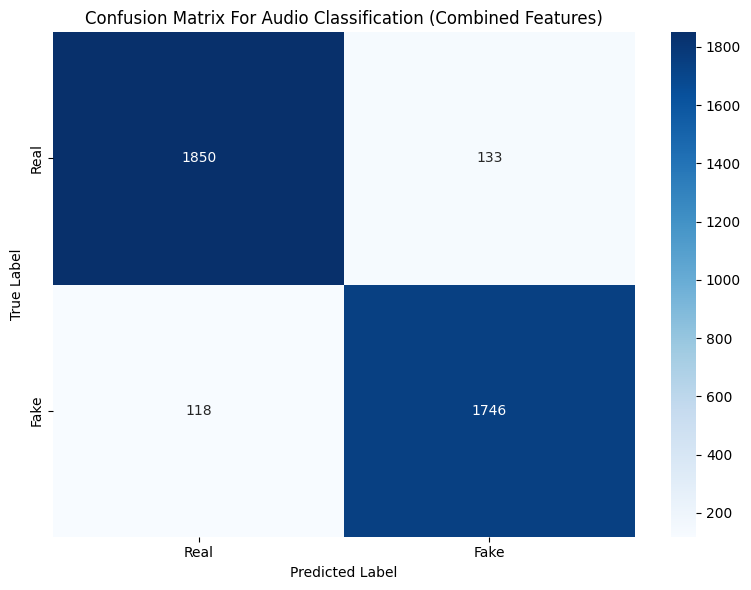

Confusion matrix plot saved to: /content/drive/My Drive/Deep Fake Dataset/models/test_confusion_matrix_audio.svg


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix', filename='confusion_matrix.png', format='png'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()

    # Save the plot
    save_path = os.path.join(OUT_MODEL_DIR, filename)
    plt.savefig(save_path, format=format)
    plt.show()
    print(f"Confusion matrix plot saved to: {save_path}")

# Predict on the test set
y_pred_test_prob = clf.predict_proba(X_test_s)[:, 1]
y_pred_test_class = (y_pred_test_prob >= 0.5).astype(int)

# Plot for the test set
plot_confusion_matrix(
    y_test,
    y_pred_test_class,
    labels=['Real', 'Fake'],
    title='Confusion Matrix For Audio Classification (Combined Features)',
    filename='test_confusion_matrix_audio.svg',
    format='svg'
)

Conducting Inference (In Preparation for Multimodal Model)

In [ ]:
# Predict on X_train_s / X_val_s / X_test_s, save CSVs, and optionally filter by modify_audio==modify_video

import os, json
from pathlib import Path
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# config
DRIVE_ROOT = Path('/content/drive/My Drive/Deep Fake Dataset')
ML_READY_DIR = DRIVE_ROOT / 'ml_ready_with_embeddings'
META_SPLITS_DIR = DRIVE_ROOT / 'metadata_splits'
MODEL_PRIMARY = DRIVE_ROOT / 'models' / 'xgb_combined_final.joblib'
MODEL_FALLBACK = DRIVE_ROOT / 'models' / 'xgb_combined_final_IGNORE.joblib'
OUT_DIR = DRIVE_ROOT / 'predictions_from_embeddings_only'
OUT_DIR.mkdir(parents=True, exist_ok=True)

SPLITS_INFO = {
    'train': {'X_var': 'X_train_s', 'y_var': 'y_train', 'npz': ML_READY_DIR / 'train.npz', 'meta_csv': META_SPLITS_DIR / 'split_train.csv'},
    'val':   {'X_var': 'X_val_s',   'y_var': 'y_val',   'npz': ML_READY_DIR / 'val.npz',   'meta_csv': META_SPLITS_DIR / 'split_val.csv'},
    'test':  {'X_var': 'X_test_s',  'y_var': 'y_test',  'npz': ML_READY_DIR / 'test.npz',  'meta_csv': META_SPLITS_DIR / 'split_test.csv'}
}

DEFAULT_THRESHOLD = 0.2
VERBOSE = True

def vprint(*a, **kw):
    if VERBOSE:
        print(*a, **kw)

# helper label parser
def parse_label_to_int(x):
    if pd.isna(x) or x is None:
        return None
    if isinstance(x, (int, np.integer)):
        return int(x)
    if isinstance(x, float):
        if np.isnan(x): return None
        return int(x)
    s = str(x).strip().lower()
    if s in ('fake','1','true','t','yes','y'):
        return 1
    if s in ('real','0','false','f','no','n'):
        return 0
    try:
        fx = float(s)
        if np.isnan(fx): return None
        return int(fx)
    except:
        return None

# Load model (prefer primary)
model_path = MODEL_PRIMARY if MODEL_PRIMARY.exists() else (MODEL_FALLBACK if MODEL_FALLBACK.exists() else None)
if model_path is None:
    raise FileNotFoundError(f"No model found. Checked:\n - {MODEL_PRIMARY}\n - {MODEL_FALLBACK}\nPlease point MODEL_PRIMARY to your saved joblib model.")
vprint("Loading model from:", model_path)
model = joblib.load(str(model_path))

# Utility: get prob for "fake" class from predict_proba (robust to class ordering)
def prob_fake_from_proba(proba_arr):
    """
    proba_arr: shape (1, C) or (C,) predicted probabilities
    returns float prob of positive class (interpreted as 'fake').
    """
    probs = np.asarray(proba_arr)
    if probs.ndim == 1:
        # single-dim: either (C,) or (N,) - assume (C,) for single sample
        if probs.shape[0] == 1:
            return float(probs.ravel()[0])
        else:
            # ambiguous, fallback to last column
            return float(probs.ravel()[-1])
    # if model has classes_ try to locate 1/'fake'; otherwise take last column
    if hasattr(model, 'classes_'):
        classes = list(model.classes_)
        for candidate in (1, '1', 'fake', 'Fake', 'FAKE'):
            if candidate in classes:
                idx = classes.index(candidate)
                return float(probs[0, idx])
    # fallback to second column if binary, else last
    if probs.shape[1] >= 2:
        return float(probs[0, 1])
    return float(probs[0, -1])

# Prepare summary
summary = {}

# Loop splits
for split, info in SPLITS_INFO.items():
    vprint(f"\n=== Split: {split} ===")
    # load X,y from memory if present; else load from npz
    X = globals().get(info['X_var'], None)
    y = globals().get(info['y_var'], None)
    if X is None or y is None:
        npz_path = info['npz']
        if not npz_path.exists():
            vprint(f"ML-ready npz for split {split} not found at {npz_path}; skipping split.")
            continue
        data = np.load(npz_path, allow_pickle=True)
        # heuristics: prefer X key
        if 'X' in data:
            X = data['X']
            y = data['y'] if 'y' in data else None
        else:
            keys = list(data.keys())
            X = data[keys[0]]
            y = data[keys[1]] if len(keys) > 1 else None
        vprint(f"Loaded {npz_path.name}: X.shape {X.shape}, y present: {y is not None}")

    # ensure numpy array
    X = np.asarray(X)
    y_arr = np.asarray(y) if y is not None else None

    # predict for all rows in X
    n = X.shape[0]
    preds = []
    for i in range(n):
        xi = X[i].reshape(1, -1)
        # predict_proba preferred
        if hasattr(model, 'predict_proba'):
            try:
                proba = model.predict_proba(xi)
                prob_fake = prob_fake_from_proba(proba)
            except Exception as e:
                # fallback to predict
                predv = model.predict(xi)
                prob_fake = float(predv[0])
        else:
            predv = model.predict(xi)
            prob_fake = float(predv[0])
        pred_default = int(prob_fake >= DEFAULT_THRESHOLD)
        preds.append({'ml_index': int(i), 'prob_fake': float(prob_fake), 'pred_default': pred_default})

    df_preds = pd.DataFrame(preds)

    # If metadata CSV present and matches X length, attach metadata
    meta_csv = info.get('meta_csv', None)
    attached_meta = False
    if meta_csv is not None and meta_csv.exists():
        meta_df = pd.read_csv(meta_csv)
        if len(meta_df) == n:
            vprint("Metadata CSV matches X length; attaching metadata columns (file_rel, modify_audio, modify_video).")
            meta_df = meta_df.reset_index().rename(columns={'index': 'ml_index'})  # ml_index = row index
            # attach relevant columns
            merge_cols = ['ml_index','file_rel']
            for c in ('modify_audio','modify_video','duration','n_fakes','label'):
                if c in meta_df.columns:
                    merge_cols.append(c)
            # drop duplicates if any and merge
            meta_subset = meta_df[merge_cols].copy()
            df_preds = df_preds.merge(meta_subset, on='ml_index', how='left')
            attached_meta = True
        else:
            vprint(f"WARNING: metadata CSV rows ({len(meta_df)}) != X rows ({n}). Skipping metadata attach for split {split}.")
    else:
        vprint("No metadata CSV found for split", split, "at", meta_csv, "; saving predictions without metadata.")

    # Save predictions CSV
    out_csv = OUT_DIR / f"mlready_predictions_{split}.csv"
    df_preds.to_csv(out_csv, index=False)
    vprint("Saved predictions:", out_csv, "rows:", len(df_preds))

    # Compute metrics using y array (if available)
    metrics = {}
    if y_arr is not None:
        y_true = np.asarray(y_arr).astype(int)
        y_pred = df_preds['pred_default'].astype(int).values
        # Ensure length alignment
        if len(y_true) != len(y_pred):
            vprint(f"WARNING: y length ({len(y_true)}) != predictions length ({len(y_pred)}). Truncating to min length.")
            mlen = min(len(y_true), len(y_pred))
            y_true = y_true[:mlen]
            y_pred = y_pred[:mlen]
            df_preds = df_preds.iloc[:mlen].reset_index(drop=True)
        try:
            prob_array = df_preds['prob_fake'].astype(float).values
            roc_auc = roc_auc_score(y_true, prob_array) if len(np.unique(y_true))>1 else None
        except Exception:
            roc_auc = None
        metrics['n_examples'] = int(len(y_true))
        metrics['accuracy'] = float(accuracy_score(y_true, y_pred))
        metrics['precision'] = float(precision_score(y_true, y_pred, zero_division=0))
        metrics['recall'] = float(recall_score(y_true, y_pred, zero_division=0))
        metrics['f1'] = float(f1_score(y_true, y_pred, zero_division=0))
        metrics['roc_auc'] = float(roc_auc) if roc_auc is not None else None
        metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred).tolist()
        vprint("Metrics (using ML-ready y labels):", metrics)
    else:
        vprint("No y available in ML-ready for split", split, "- skipping metrics against ground truth y.")

    # If metadata attached, create filtered CSV where modify_audio == modify_video and compute accuracy on that subset
    filtered_count = None
    filtered_acc = None
    if attached_meta and ('modify_audio' in df_preds.columns) and ('modify_video' in df_preds.columns):
        mask = df_preds['modify_audio'].notnull() & df_preds['modify_video'].notnull() & (df_preds['modify_audio'] == df_preds['modify_video'])
        df_filtered = df_preds[mask].copy()
        out_filt = OUT_DIR / f"mlready_predictions_{split}_modalitymatched2.csv"
        df_filtered.to_csv(out_filt, index=False)
        filtered_count = int(len(df_filtered))
        vprint(f"Saved filtered modality-matched CSV: {out_filt} rows: {filtered_count}")
        # compute accuracy using modify_audio as ground truth, if parseable
        df_filtered['y_true_meta'] = df_filtered['modify_audio'].apply(parse_label_to_int)
        valid = df_filtered[df_filtered['y_true_meta'].notnull()].copy()
        if len(valid) > 0:
            y_true_meta = valid['y_true_meta'].astype(int).values
            y_pred_meta = valid['pred_default'].astype(int).values
            filtered_acc = float(accuracy_score(y_true_meta, y_pred_meta))
            vprint(f"Accuracy on filtered rows (modify_audio == modify_video) for split {split}: {filtered_acc:.4f} (n={len(valid)})")
        else:
            vprint("No parseable modify_audio labels in filtered set to compute accuracy.")
    else:
        vprint("Metadata not attached or modify flags missing; skipping modality filtering for split", split)

    # Save per-split summary
    summary = {
        'n_predictions': int(len(df_preds)),
        'metrics_vs_mlready_y': metrics if metrics else None,
        'filtered_n': filtered_count,
        'filtered_accuracy': filtered_acc,
        'predictions_csv': str(out_csv),
        'filtered_csv': str(out_filt) if ('out_filt' in locals() and 'df_filtered' in locals()) else None
    }
    summary_path = OUT_DIR / f"summary_{split}.json"
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    vprint("Saved summary for split", split, "->", summary_path)

vprint("\nAll splits processed. CSVs and summaries are in:", OUT_DIR)

In [ ]:
# Combine modality matched test/val sets into final dataset for multimodal training

import os
import pandas as pd
from pathlib import Path

# Define paths
DRIVE_ROOT = Path('/content/drive/My Drive/Deep Fake Dataset')
PREDICTIONS_DIR = DRIVE_ROOT / 'predictions_from_mlready_arrays'

# Input CSV files
val_predictions_path = PREDICTIONS_DIR / 'mlready_predictions_val_modalitymatched2.csv'
test_predictions_path = PREDICTIONS_DIR / 'mlready_predictions_test_modalitymatched2.csv'

# Output combined CSV file
combined_predictions_path = PREDICTIONS_DIR / 'predictions_audio_FINAL2.csv'

# Load the predictions into pandas DataFrames
print(f"Loading {val_predictions_path}")
df_val_predictions = pd.read_csv(val_predictions_path)

print(f"Loading {test_predictions_path}")
df_test_predictions = pd.read_csv(test_predictions_path)

# Combine the DataFrames
df_combined_predictions = pd.concat([df_val_predictions, df_test_predictions], ignore_index=True)

# Save the combined DataFrame to a new CSV file
df_combined_predictions.to_csv(combined_predictions_path, index=False)

print(f"Combined {len(df_val_predictions)} rows from validation and {len(df_test_predictions)} rows from test into {len(df_combined_predictions)} rows.")
print(f"Combined predictions saved to: {combined_predictions_path}")

Loading /content/drive/My Drive/Deep Fake Dataset/predictions_from_mlready_arrays/mlready_predictions_val_modalitymatched2.csv
Loading /content/drive/My Drive/Deep Fake Dataset/predictions_from_mlready_arrays/mlready_predictions_test_modalitymatched2.csv
Combined 1992 rows from validation and 1976 rows from test into 3968 rows.
Combined predictions saved to: /content/drive/My Drive/Deep Fake Dataset/predictions_from_mlready_arrays/predictions_audio_FINAL2.csv


In [ ]:
#Evaluate accuracy on modality matched data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import os
from pathlib import Path

# Define paths
DRIVE_ROOT = Path('/content/drive/My Drive/Deep Fake Dataset')
PREDICTIONS_DIR = DRIVE_ROOT / 'predictions_from_mlready_arrays'
OUT_MODEL_DIR = DRIVE_ROOT / 'models'

# Load the final sampled predictions CSV
sampled_predictions_path = PREDICTIONS_DIR / 'mlready_predictions_test_modalitymatched2.csv'
print(f"Loading sampled predictions from: {sampled_predictions_path}")
df_predictions = pd.read_csv(sampled_predictions_path)

# Filter data to keep only rows where modify_audio == modify_video
# 'modify_audio' and 'modify_video' are boolean, and 'pred_default' is 0/1 int
df_filtered = df_predictions[df_predictions['modify_audio'] == df_predictions['modify_video']].copy()

print(f"Original samples: {len(df_predictions)}")
print(f"Filtered samples (modify_audio == modify_video): {len(df_filtered)}")

# Create the 'y_true_filtered' and 'y_pred_filtered' columns within df_filtered
# 'modify_audio' (True/False) is cast to 1/0 for true labels
df_filtered['y_true_filtered'] = df_filtered['modify_audio'].astype(int);
# 'pred_default' (0/1) directly serves as predicted labels
df_filtered['y_pred_filtered'] = df_filtered['pred_default'].astype(int)

# Function for plotting confusion matrix (pasted from prev code)
def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix', filename='confusion_matrix.png', format='png'):
    cm = confusion_matrix(y_true, y_pred);
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()

    # Save the plot
    save_path = os.path.join(OUT_MODEL_DIR, filename)
    plt.savefig(save_path, format=format)
    plt.show()
    print(f"Confusion matrix plot saved to: {save_path}")

# Generate and plot the confusion matrix for the filtered data
plot_confusion_matrix(
    df_filtered['y_true_filtered'],
    df_filtered['y_pred_filtered'],
    labels=['Real', 'Fake'],
    title='Confusion Matrix For Classification With Matched Samples (Combined Features)',
    filename='confusion_matrix_modality_matched_audio.svg', # Changed filename extension
    format='svg' # Added format parameter
)

# Print accuracy for the filtered subset
filtered_accuracy = accuracy_score(df_filtered['y_true_filtered'], df_filtered['y_pred_filtered'])
print(f"Accuracy on filtered data (modify_audio == modify_video): {filtered_accuracy:.4f}")

Ablation Study: Embeddings Only

In [ ]:
#Building ML dataset using only embeddigns as features

import os, shutil, time
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
import joblib

# configs
DATA_ROOT = '/content/drive/My Drive/Deep Fake Dataset'
META_DIR = os.path.join(DATA_ROOT, 'metadata_splits')
EMBED_DIR_DRIVE   = os.path.join(DATA_ROOT, 'embeddings', 'wav2vec2-base')
LOCAL_EMBED_DIR   = '/content/embeddings_only'
OUT_ML_DIR = os.path.join(DATA_ROOT, 'ml_ready_embeddings_only')
os.makedirs(OUT_ML_DIR, exist_ok=True)

# threading
N_JOBS = min(8, (os.cpu_count() or 4))
LIMIT = None
VERBOSE = True

t_all_start = time.time()

# 1) copy embeddings folder locally (fast I/O)
def copy_if_missing(src, dst):
    if os.path.exists(dst):
        print(f"Local copy exists: {dst} (skipping copy)")
        return
    print(f"Copying {src} -> {dst} (this may take several minutes)...")
    shutil.copytree(src, dst)
    print("Copy done.")

copy_if_missing(EMBED_DIR_DRIVE, LOCAL_EMBED_DIR)

# helpers

def flatten_embedding_npz(npz_obj):
    """
    Prefer wav2vec2_mean + wav2vec2_std (best signal).
    Fallback: flatten all keys.
    """
    if 'wav2vec2_mean' in npz_obj and 'wav2vec2_std' in npz_obj:
        mean_v = np.asarray(npz_obj['wav2vec2_mean']).ravel()
        std_v  = np.asarray(npz_obj['wav2vec2_std']).ravel()
        return np.concatenate([mean_v, std_v]).astype(np.float32)
    else:
        keys = sorted(list(npz_obj.keys()))
        parts = [np.asarray(npz_obj[k]).ravel() for k in keys]
        return np.concatenate(parts).astype(np.float32)

# Find one sample to detect embedding dimensionality
def find_embedding_sample(split_csv, local_embed_dir=LOCAL_EMBED_DIR):
    df = pd.read_csv(split_csv)
    for r in df.itertuples(index=False):
        stem = Path(r.file_rel).stem
        emb = os.path.join(local_embed_dir, stem + '.npz')
        if os.path.exists(emb):
            return emb
    return None

def compute_embed_dim(emb_path):
    d = np.load(emb_path)
    v = flatten_embedding_npz(d)
    return v.shape[0]

# parallel worker
def load_embed_row(row, local_embed_dir=LOCAL_EMBED_DIR):
    stem = Path(row.file_rel).stem
    emb_path = os.path.join(local_embed_dir, stem + '.npz')
    if not os.path.exists(emb_path):
        return (stem, None, None, "missing embedding")
    try:
        d = np.load(emb_path)
        x = flatten_embedding_npz(d)
        y = 1 if row.label == 'fake' else 0
        return (stem, x, y, None)
    except Exception as e:
        return (stem, None, None, str(e))

# Process split
def process_split(split_csv, limit=None):
    df = pd.read_csv(split_csv)
    if limit:
        df = df.iloc[:limit]
    total = len(df)

    print(f"\nProcessing split {split_csv} -> {total} rows")

    # detect dim
    emb_sample = find_embedding_sample(split_csv)
    if not emb_sample:
        raise RuntimeError("No embedding file found for split: " + split_csv)
    dim = compute_embed_dim(emb_sample)
    print("Detected embedding vector dimension:", dim)

    # preallocate
    X = np.zeros((total, dim), dtype=np.float32)
    y = np.zeros((total,), dtype=np.int64)
    missing = []

    rows = list(df.itertuples(index=False))

    results = Parallel(n_jobs=N_JOBS, backend="threading")(
        delayed(load_embed_row)(r, LOCAL_EMBED_DIR) for r in tqdm(rows)
    )

    filled = 0
    for stem, xvec, lab, err in results:
        if xvec is None:
            missing.append((stem, err))
            continue
        X[filled, :xvec.shape[0]] = xvec
        y[filled] = lab
        filled += 1

    print(f"Filled {filled}/{total} rows; missing {len(missing)}")
    return X[:filled], y[:filled], missing

# BUILD SPLITS

train_csv = os.path.join(META_DIR, 'split_train.csv')
val_csv   = os.path.join(META_DIR, 'split_val.csv')
test_csv  = os.path.join(META_DIR, 'split_test.csv')

X_train, y_train, miss_train = process_split(train_csv, limit=LIMIT)
X_val,   y_val,   miss_val   = process_split(val_csv,   limit=LIMIT)
X_test,  y_test,  miss_test  = process_split(test_csv,  limit=LIMIT)

print("\nMissing (train/val/test):", len(miss_train), len(miss_val), len(miss_test))
print("Shapes before scaling:")
print("  X_train:", X_train.shape)
print("  X_val:  ", X_val.shape)
print("  X_test: ", X_test.shape)

# SCALE

print("\nScaling (fit on train only)...")

scaler = StandardScaler()
if X_train.size == 0:
    raise RuntimeError("No training data!")
scaler.fit(X_train)

X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

joblib.dump(scaler, os.path.join(OUT_ML_DIR, 'scaler_embeddings_only.joblib'))

# SAVE

np.savez_compressed(os.path.join(OUT_ML_DIR, 'train.npz'), X=X_train_s, y=y_train)
np.savez_compressed(os.path.join(OUT_ML_DIR, 'val.npz'),   X=X_val_s,   y=y_val)
np.savez_compressed(os.path.join(OUT_ML_DIR, 'test.npz'),  X=X_test_s,  y=y_test)

t2 = time.time()
print("\n=== DONE ===")
print("Saved embeddings-only ML datasets to:", OUT_ML_DIR)
print("Total time:", round(t2 - t_all_start, 1), "seconds")

N_JOBS: 2
Copying /content/drive/My Drive/Deep Fake Dataset/embeddings/wav2vec2-base -> /content/embeddings_only (this may take several minutes)...
Copy done.

Processing split /content/drive/My Drive/Deep Fake Dataset/metadata_splits/split_train.csv -> 17948 rows
Detected embedding vector dimension: 1536


100%|██████████| 17948/17948 [00:21<00:00, 847.44it/s]


Filled 17948/17948 rows; missing 0

Processing split /content/drive/My Drive/Deep Fake Dataset/metadata_splits/split_val.csv -> 3846 rows
Detected embedding vector dimension: 1536


100%|██████████| 3846/3846 [00:04<00:00, 799.57it/s]


Filled 3846/3846 rows; missing 0

Processing split /content/drive/My Drive/Deep Fake Dataset/metadata_splits/split_test.csv -> 3847 rows
Detected embedding vector dimension: 1536


100%|██████████| 3847/3847 [00:05<00:00, 680.69it/s]


Filled 3847/3847 rows; missing 0

Missing (train/val/test): 0 0 0
Shapes before scaling:
  X_train: (17948, 1536)
  X_val:   (3846, 1536)
  X_test:  (3847, 1536)

Scaling (fit on train only)...

=== DONE ===
Saved embeddings-only ML datasets to: /content/drive/My Drive/Deep Fake Dataset/ml_ready_embeddings_only
Total time: 821.7 seconds


In [ ]:
# Train XGBoost classifier on embeddings only
from xgboost import XGBClassifier
import os
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import joblib
import json

# Define paths (if not already defined in this cell or implicitly available)
DATA_ROOT = '/content/drive/My Drive/Deep Fake Dataset'
ML_READY_DIR = os.path.join(DATA_ROOT, 'ml_ready_embeddings_only')
OUT_MODEL_DIR = os.path.join(DATA_ROOT, 'models')
os.makedirs(OUT_MODEL_DIR, exist_ok=True)

# Load the standardized datasets and scaler
print("Loading ML-ready datasets...")
train_npz = np.load(os.path.join(ML_READY_DIR, 'train.npz'))
val_npz   = np.load(os.path.join(ML_READY_DIR, 'val.npz'))
test_npz  = np.load(os.path.join(ML_READY_DIR, 'test.npz'))

X_train_s = train_npz['X']
y_train = train_npz['y']
X_val_s   = val_npz['X']
y_val   = val_npz['y']
X_test_s  = test_npz['X']
y_test  = test_npz['y']

scaler = joblib.load(os.path.join(ML_READY_DIR, 'scaler_embeddings_only.joblib'))

print("Data loaded. Shapes:")
print(f"X_train_s: {X_train_s.shape}, y_train: {y_train.shape}")
print(f"X_val_s:   {X_val_s.shape}, y_val:   {y_val.shape}")
print(f"X_test_s:  {X_test_s.shape}, y_test:  {y_test.shape}")

#defaut params = best params from CV
best_params = {'colsample_bytree': np.float64(0.776382483417745),
                'gamma': np.float64(0.0014145953382213344),
                'learning_rate': np.float64(0.2805876934404873),
                'max_depth': 6,
                'min_child_weight': 1,
                'n_estimators': 355,
                'reg_alpha': np.float64(0.0002330874380942336),
                'reg_lambda': np.float64(2.2603818105733772e-05),
                'subsample': np.float64(0.7578765867237889),
                'use_label_encoder': False,
                'objective': 'binary:logistic',
                'n_jobs': -1,
                'random_state': 42,
                'tree_method': 'hist',
                'eval_metric': 'auc'
}

clf_params = best_params.copy()
# remove any keys that XGBClassifier won't accept directly
for bad in ['verbosity', 'eval_metric']:
    if bad in clf_params:
        clf_params.pop(bad)

print("\nFinal params for XGBClassifier:")
print({k: clf_params[k] for k in ['n_estimators','max_depth','learning_rate'] if k in clf_params})

clf = XGBClassifier(**clf_params)
print("Training XGBoost on combined features... (may take a few minutes)")
clf.fit(X_train_s, y_train)

# Evaluate on val and test
def eval_and_print(model, Xv, yv, setname):
    probs = model.predict_proba(Xv)[:,1]
    preds = (probs >= 0.5).astype(int)
    print(f"\n--- {setname} Evaluation ---")
    print("Accuracy: ", accuracy_score(yv, preds))
    print("Precision:", precision_score(yv, preds))
    print("Recall:   ", recall_score(yv, preds))
    print("F1 score: ", f1_score(yv, preds))
    print("ROC AUC:  ", roc_auc_score(yv, probs))
    print("Confusion matrix (tn, fp; fn, tp):")
    print(confusion_matrix(yv, preds))
    print("\nClassification report:")
    print(classification_report(yv, preds, digits=4))

eval_and_print(clf, X_val_s, y_val, "VALIDATION")
eval_and_print(clf, X_test_s, y_test, "TEST (holdout)")

# Save final model and params
model_path = os.path.join(OUT_MODEL_DIR, 'xgb_combined_final.joblib')
joblib.dump(clf, model_path)
with open(os.path.join(OUT_MODEL_DIR, 'xgb_combined_final_params.json'), 'w') as f:
    json.dump(clf_params, f, indent=2)
print("\nSaved XGBoost model to:", model_path)


Loading ML-ready datasets...
Data loaded. Shapes:
X_train_s: (17948, 1536), y_train: (17948,)
X_val_s:   (3846, 1536), y_val:   (3846,)
X_test_s:  (3847, 1536), y_test:  (3847,)

Final params for XGBClassifier:
{'n_estimators': 355, 'max_depth': 6, 'learning_rate': np.float64(0.2805876934404873)}
Training XGBoost on combined features... (may take a few minutes)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:14:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- VALIDATION Evaluation ---
Accuracy:  0.9191367654706188
Precision: 0.9114528101802757
Recall:    0.9227053140096618
F1 score:  0.9170445452120566
ROC AUC:   0.9778587667746971
Confusion matrix (tn, fp; fn, tp):
[[1816  167]
 [ 144 1719]]

Classification report:
              precision    recall  f1-score   support

           0     0.9265    0.9158    0.9211      1983
           1     0.9115    0.9227    0.9170      1863

    accuracy                         0.9191      3846
   macro avg     0.9190    0.9192    0.9191      3846
weighted avg     0.9192    0.9191    0.9191      3846


--- TEST (holdout) Evaluation ---
Accuracy:  0.9264361840395113
Precision: 0.9184753838009528
Recall:    0.930793991416309
F1 score:  0.924593658406608
ROC AUC:   0.9809978162016626
Confusion matrix (tn, fp; fn, tp):
[[1829  154]
 [ 129 1735]]

Classification report:
              precision    recall  f1-score   support

           0     0.9341    0.9223    0.9282      1983
           1     0.9185    0